In [1]:
using Plots
using LaTeXStrings
using LinearAlgebra
using FFTW
using BenchmarkTools
using Distributions
using Unwrap
using JuMP
using Ipopt
using Unwrap

In [2]:
function fftnshift(A::AbstractArray)
    B = copy(A)
    return fftshift(fft(B))
end
function ifftnshift(A::AbstractArray)
    B = copy(A)
    return ifft(ifftshift(B))
end

ifftnshift (generic function with 1 method)

In [3]:
function Pixelate_Reciprocal(image, camera_scale, physical_scale)
    # This function pixelates the image in the reciprocal space
    # It is assumed that the image is already in the reciprocal space and normally ordered
    # the averaging kernel is Fourier transform where the scaling ratio its size

    Ny, Nx = size(image)
    N = Nx
    scaling_ratio = round(Int, camera_scale/physical_scale)

    Nx_camera = Nx ÷ scaling_ratio
    Ny_camera = Ny ÷ scaling_ratio
    N_camera = Nx_camera
    

    upper = (N-1)/2 
    lower = (-N+1)/2
    kx = @. (lower:1.0:upper) * 1/(physical_scale*N )
    ky = @. (lower:1.0:upper) * 1/(physical_scale*N )

    prod = @. sinc(kx * scaling_ratio)
    FT_kernel = prod * prod'
    image_lowpass = @. FT_kernel .* image
    
    
    slct_low = (N-N_camera)÷2 + 1
    slct_high = slct_low + N_camera - 1
    kx_pixelated = kx[slct_low:slct_high]
    ky_pixelated = ky[slct_low:slct_high]
    
    image_pixelated = image_lowpass[slct_low:slct_high, slct_low:slct_high]
    image_pixelated = @. image_pixelated/ scaling_ratio^2
    return image_pixelated, kx_pixelated, ky_pixelated
end

Pixelate_Reciprocal (generic function with 1 method)

In [4]:


function Noisy_Image(A::AbstractMatrix{<:Number}, N_electrons::T ,
            background_noise::U, kspace=false) where {T<:Real,U<:Real}


    image = copy(A)
    if kspace
        # image is assumed to be in reciprocal space and normally ordered
        image = ifftnshift(image)
    end
    image = abs.(image) # image is assumed to be in real-space and real

    
    image_normalized = N_electrons .* image./sum(image)
    background_noise = rand(Poisson(background_noise), size(image))
    image_poisson =  rand.(Poisson.(image_normalized))
    image_noisy = image_poisson .+ background_noise

    if kspace
        image_noisy = fftnshift(image_noisy)
        return image_noisy
    end

    return image_noisy
end



Noisy_Image (generic function with 2 methods)

In [5]:
function Find_Crossing(func, y_point, x)
    N = length(func)
    f = func .- y_point
    x_intercepts = []

    for i in 1:N-1
        if f[i]*f[i+1] < 0
            # Linear interpolation to find the crossing point
            dfdx = (f[i+1] - f[i]) / (x[i+1] - x[i])
            x_intercept = x[i] - f[i]/dfdx
            x_intercepts = push!(x_intercepts, x_intercept)
        end
        
    end
    return x_intercepts
end
function Find_Spacing(x_intercepts)
    if length(x_intercepts) == 0
        return Inf
    end


    if mod(length(x_intercepts),2) == 1
        x_intercepts = x_intercepts[1:end-1]
    end
    centers = @. (x_intercepts[1:2:end] + x_intercepts[2:2:end])/2
    
    spacing = centers[2:end] .- centers[1:end-1]
    spacing = sort!(spacing)
    return spacing[length(spacing)÷2]
end

Find_Spacing (generic function with 1 method)

In [6]:
function Diff_Image(image, c=0.01)
    return @. log1p(c*abs(image))
end
function Autocorrelation(image)
    # the image is assumed to be in real space
    
    image_fft = fftnshift(image)
    image_auto = ifftnshift(image_fft .* conj.(image_fft))
    if eltype(image) <: Real 
        return real.(image_auto)
    end
    return image_auto
end
function Autocorrelation_Normalized(image)
    # the image is assumed to be in real space
    Ny, Nx = size(image)
    image_auto = Autocorrelation(image)
    image_auto = image_auto./(Ny*Nx)
    image_auto = image_auto .- sum(image_auto)/(Ny*Nx)
    image_auto = image_auto ./ maximum(abs.(image_auto))
    return image_auto
end

Autocorrelation_Normalized (generic function with 1 method)

In [7]:
function Wavelength(E)
    hc = 12.398 #keV*Angstrom
    # h = 6.582119e-16 #eV*sec
    # mc2 = 511 #keV
    E₀ = 511 #keV
    return hc/sqrt(E*(2*E₀ + E))
end

function Focus(E, Cs, nᵢ=1)
    return sqrt((2*nᵢ-0.5)*Cs*Wavelength(E))
end
kmax(E, Cs) = (6/((Cs*Wavelength(E)^3)))^(1/4)

function TEM_Image(wf_transmission, E, Cs)
    Ny, Nx = size(wf_transmission)
    if Nx != Ny
        error("Image must be square")
    elseif 2^(floor(Int, log2(Nx))) != Nx
        error("Image must be power of 2")
    end
    N = Nx

    upper = (N-1)/2 + 0.1
    lower = (-N+1)/2
    kx = lower:1.0:upper
    ky = lower:1.0:upper

    k = @. sqrt(kx'^2 + ky^2)
    disk = k.<=N/2

    λ = Wavelength(E)
    Δf = Focus(E, Cs)
    Hₒ = @. exp(-1im*(π*λ*k^2*(0.5*Cs*λ^2*k^2 - Δf)))*disk
    
    fft_ideal_image = fftnshift(wf_transmission)
    fft_physical_image = fft_ideal_image.*Hₒ
    image_physical = ifftnshift(fft_physical_image)
    
    return image_physical
end

TEM_Image (generic function with 1 method)

In [349]:
E = 300
Cs = 1 #mm
Cs = Cs * 1e7 #convert to Angstroms

N = 2^8
physical_scale = 1
camera_scale = 2

upper = (N-1)/2 + 0.1
lower = (-N+1)/2
kx = lower:1:upper
ky = lower:1:upper

k = @. sqrt(kx'^2 + ky^2)
disk = k.<=N/2

kx = kx./maximum(kx).*kmax(E, Cs)
ky = ky./maximum(ky).*kmax(E, Cs)
k = @. sqrt(kx'^2 + ky^2)

Δk = kx[2] - kx[1]
L = 1/Δk
ΔL = L/N

x = LinRange(-L/2, L/2, N)
y = LinRange(-L/2, L/2, N)

λ(E) = Wavelength(E)
Δf(E, Cs) = Focus(E, Cs)

H = @. exp(-1im*(π*λ(E)*k^2*(0.5*Cs*λ(E)^2*k^2 - Δf(E, Cs)))*disk)*disk
f(x, y, xc, yc, σ₁, σ₂) = @. (1/((2*pi)*sqrt(σ₁*σ₂)))*exp(-(x - xc)^2/(2σ₁^2) -(y - yc)^2/(2σ₂^2) )
heatmap(kx, ky, angle.(H), title="angle of the tansfer function H",  
        xlabel=L"k_x\, Å^{-1}", ylabel=L"k_y\, Å^{-1}", aspect_ratio=1)
xlims!(kx[1], kx[end])
ylims!(ky[1], ky[end]);

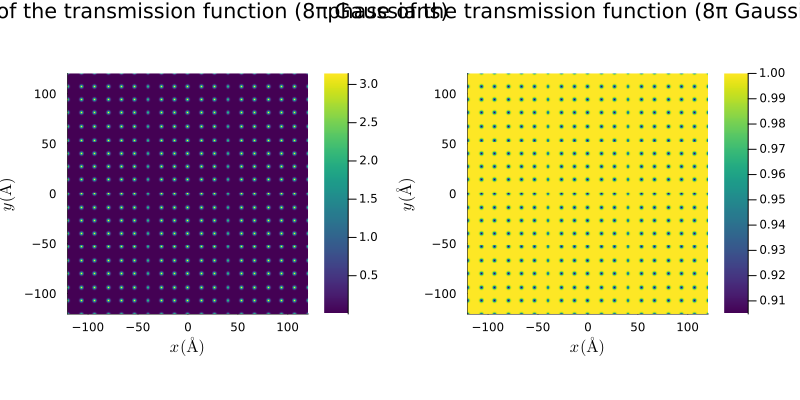

In [351]:
S = 19
σ₊, σ₋ = 1, 1
phase_real = zeros(N, N)
phase_complex = zeros(N, N)
indices = round.(Int, LinRange(1, N, S))
# for i in indices, j in indices
#     phase[j, i] += 1
# end
for i in indices, j in indices
    xc = x[i]
    yc = y[j]
    phase_real += f(x',y, xc, yc, σ₊, σ₋)
    phase_complex += f(x',y, xc, yc, σ₊, σ₋) 
end


phase_real = phase_real./maximum(phase_real) *π
phase_complex = phase_complex./maximum(phase_complex) * 0.1
phase = phase_real + 1im*phase_complex

Ψₜ = @. exp(1im*phase)
fig1 = heatmap(x,y,abs.(phase), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
xlabel!(L"x\, (Å)")
ylabel!(L"y\, (Å)")
xlims!(-L/2, L/2)
ylims!(-L/2, L/2)
title!("angle of tramission function (8π Gaussians)")
# vline!([spacing_x], color=:black, lw=2)
# hline!([spacing_y], color=:black, lw=2)

fig2 = heatmap(x,y,abs.(Ψₜ), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
xlabel!(L"x\, (Å)")
ylabel!(L"y\, (Å)")
xlims!(-L/2, L/2)
ylims!(-L/2, L/2)

plot(fig1, fig2, layout=(1,2), size=(800, 400), title="phase of the transmission function (8π Gaussians)", legend=false)

spacing: 13.218789452088316


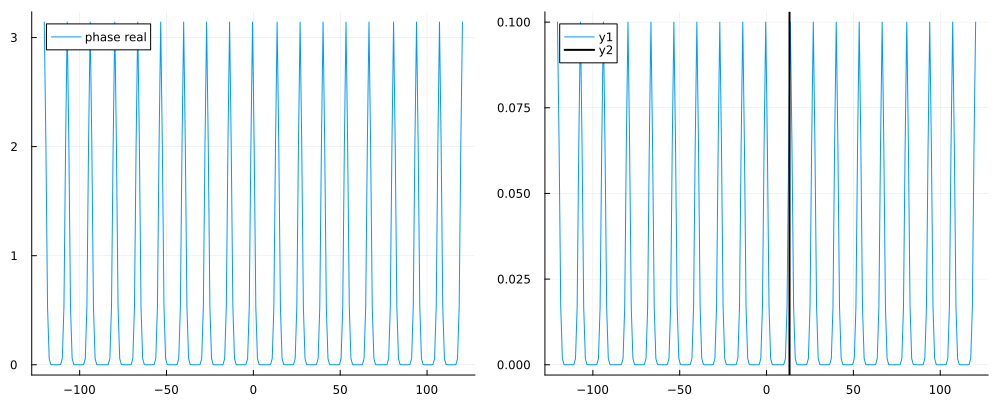

In [352]:
x_intercepts = Find_Crossing(phase_real[:, 1], 3, x)
spacing = Find_Spacing(x_intercepts)
println("spacing: ", spacing)
fig = plot(x,phase_real[:, 1], label="phase real")
fig2 = plot(x,phase_complex[:,1])
vline!([spacing], color=:black, lw=2)
plot(fig,fig2, layout=(1,2), size=(1000,400))


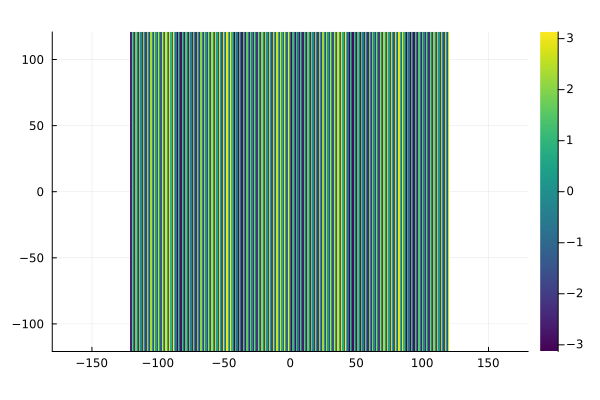

In [353]:
# Define the incident angle (θ) in radians and wave vector magnitude (k0)
θ = deg2rad(2)      # incident angle (radians)
ϕ = deg2rad(0) # azimuthal angle (radians)

# Wavevector components; here we tilt the plane wave along x-direction
kmag = 2 * pi / Wavelength(300)


# Create the plane wave by computing the phase exp(i*(kx*x + ky*y))
ref_wave = @. exp(1im * kmag * (sin(θ)*cos(ϕ)*x' + sin(θ)*sin(ϕ)*y))

# Plot the amplitude
# heatmap(abs.(ref_wave), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
heatmap(x,y,angle.(ref_wave), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)

\begin{align}
    \psi_{ref}(x) &= A e^{i\vec{k} \cdot \vec{r}}\\
    &= A e^{i|k| \hat{k} \cdot \vec{r} }\\
    &= A e^{i|k|(\sin(\theta)\hat{y},cos(\theta)\hat{z}) \cdot (x,y) }
\end{align}

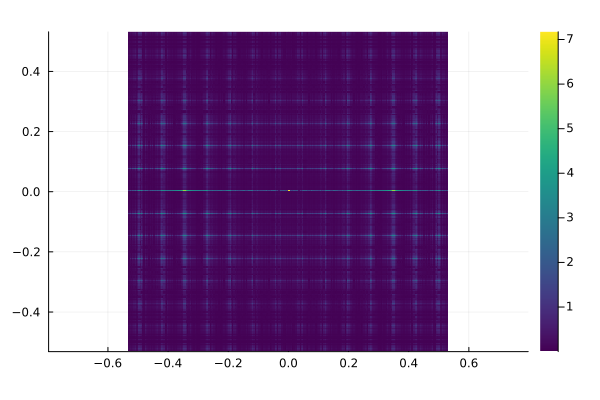

In [354]:
Ψₜ = @. exp(1im*phase)

ideal_measured = abs2.(Ψₜ .+ ref_wave )
ideal_fft = fftnshift(ideal_measured)
heatmap(kx,ky,Diff_Image(ideal_fft,0.01), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)

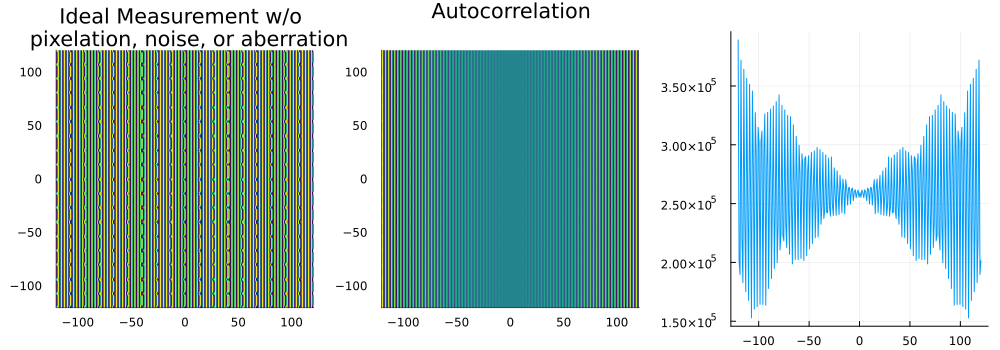

In [361]:
ideal_autocorr = Autocorrelation(ideal_measured)
fig1 = heatmap(x,y, ideal_measured, aspect_ratio=1, c=:viridis, 
    colorbar=false, axis=true)
    xlims!(-L/2, L/2)
    ylims!(-L/2, L/2)
    title!("Ideal Measurement w/o \n pixelation, noise, or aberration") 
fig2 = heatmap(x,y, ideal_autocorr, aspect_ratio=1, c=:viridis, 
colorbar=false, axis=true, title="Autocorrelation")
xlims!(-L/2, L/2)
ylims!(-L/2, L/2)
fig3 = plot(x,ideal_autocorr[1,:], label=false)
# title!("Ideal Measurement w/o \n pixelation, noise, or aberration\n") 
plot(fig1, fig2, fig3, layout=(1,3), size=(1000,350))

In [17]:
using ImageFiltering
using Unwrap

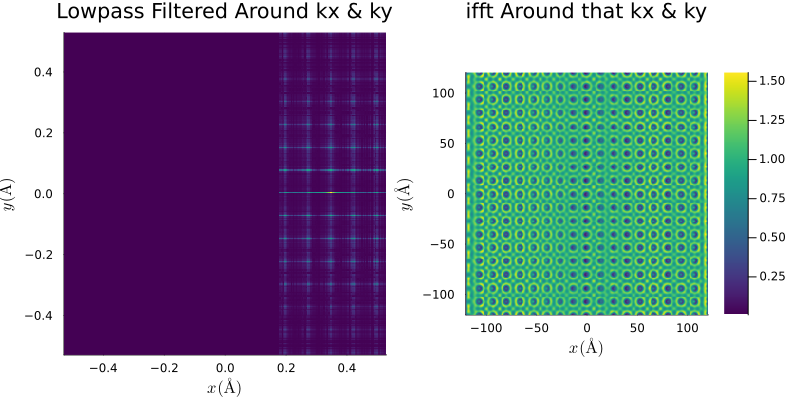

In [362]:
shifts = 1/Δx + 0.01
shifts_y = 1/Δy 
kx_disk = kx .- shifts
ky_disk = ky .- shifts_y

r_disk = @. sqrt(kx_disk'^2 + ky_disk^2)
# fft_smalldisk = r_disk.<=N/2*Δk
fft_disk = r_disk.<= shifts/2
mask = kx'.*ky./ky .>= shifts/2
mask = mask .& (kx'.*ky./ky .<= 3*shifts/2)
mask2 = kx'.*ky./ky .<= -shifts/2

 
ideal_unwrapped_lowpass = fftnshift(ideal_measured).*mask
ideal_test2 = fftnshift(ideal_measured).*mask2
ideal_unwrapped_lowpass_real = ifftnshift(fftnshift(ideal_measured).*fft_disk)
test = copy(ideal_unwrapped_lowpass_real)
fig1 = heatmap(kx,ky, Diff_Image(ideal_unwrapped_lowpass,0.01), aspect_ratio=1, c=:viridis, colorbar=false, axis=true)
xlims!(kx[1], kx[end])
ylims!(ky[1], ky[end])
title!("Lowpass Filtered Around kx & ky")

fig2 = heatmap(x,y,abs2.(test), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
xlims!(x[1], x[end])
ylims!(y[1], y[end])
title!("ifft Around that kx & ky")
plot(fig1, fig2, layout=(1,2), size=(800, 400), 
    xlabel=L"x\, (Å)", ylabel=L"y\, (Å)")

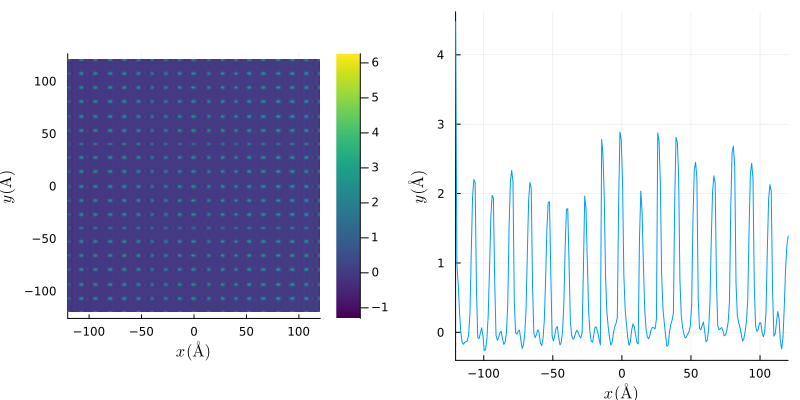

In [379]:
shifts = round(Int,1/Δx/Δk  )
shifts_y = round(Int,1/Δy/Δk )
test_shifted = circshift(fftnshift(ideal_measured).*mask, (shifts_y, -shifts))
test_reconstructed = ifftnshift(test_shifted)/(π*shifts^2/(4*N^2))
phase_reconstruced = atan.(imag.(test_reconstructed), real.(test_reconstructed))
phase_unwrapped = unwrap(phase_reconstruced, (true,true))
gradient = .+2.1 .-x.*1.5 ./maximum(x)
phase_unwrapped = phase_unwrapped .+ reshape(gradient,(1,N))
fig1 = heatmap(x,y,phase_unwrapped, aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
xlims!(-L/2, L/2)
fig2 = plot(x,phase_unwrapped[N÷2,:], label=false)
xlims!(-L/2, L/2)
plot(fig1, fig2, layout=(1,2), size=(800, 400), 
    xlabel=L"x\, (Å)", ylabel=L"y\, (Å)")

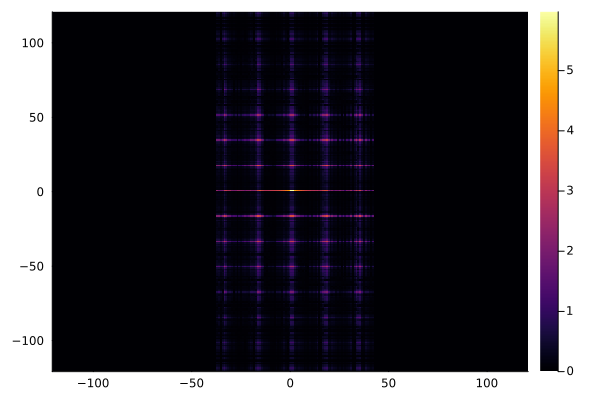

In [365]:
heatmap(x,y,Diff_Image(test_shifted))

In [102]:
# spacing_x = (-N/2:64:N/2).*Δx
# spacing_y = (-N/2:64:N/2).*Δy
shift = 50
fig = plot(x,reconstructed_autocorr[shift,:], label="autocorr")
plot!(y, reconstructed_autocorr[:,shift], label="autocorr", linestyle=:dash)

x_intercepts = Find_Crossing(reconstructed_autocorr[shift,:], maximum(reconstructed_autocorr[shift,:])/2, x)
y_intercepts = Find_Crossing(reconstructed_autocorr[:,shift], maximum(reconstructed_autocorr[:,shift])/2, y)
x_spacing = Find_Spacing(x_intercepts)
y_spacing = Find_Spacing(y_intercepts)
println("spacing: ", x_spacing, " ", y_spacing)
println("spacing in pixels: ", x_spacing/ΔL, " ", y_spacing/ΔL)
println(ΔL)
vline!([x_spacing])
display(fig)
# plot!(y, test_reconstruct[:,1], label="reconstructed")

UndefVarError: UndefVarError: `reconstructed_autocorr` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

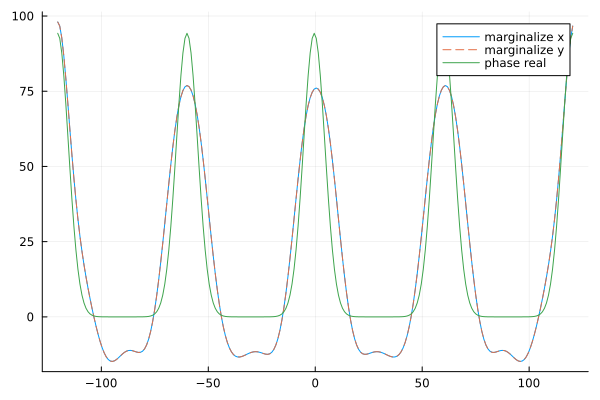

spacing: 60.39147618039582 60.39147618039598
spacing in pixels: 64.21134704194952 64.2113470419497
0.9405109682707924


In [52]:
marginalize_x = dropdims(sum(reconstructed_autocorr, dims=1), dims=1)
marginalize_y = dropdims(sum(reconstructed_autocorr, dims=2), dims=2)
fig = plot(x, marginalize_x, label="marginalize x")
plot!(y, marginalize_y, label="marginalize y", linestyle=:dash)
plot!(x,phase_real[:, 1].*10, label="phase real")
# vline!([x_spacing], color=:black, lw=2)
display(fig)

x_intercepts = Find_Crossing(marginalize_x, maximum(marginalize_x)/2, x)
y_intercepts = Find_Crossing(marginalize_y, maximum(marginalize_y)/2, y)
x_spacing = Find_Spacing(x_intercepts)
y_spacing = Find_Spacing(y_intercepts)
println("spacing: ", x_spacing, " ", y_spacing)
println("spacing in pixels: ", x_spacing/ΔL, " ", y_spacing/ΔL)
println(ΔL)

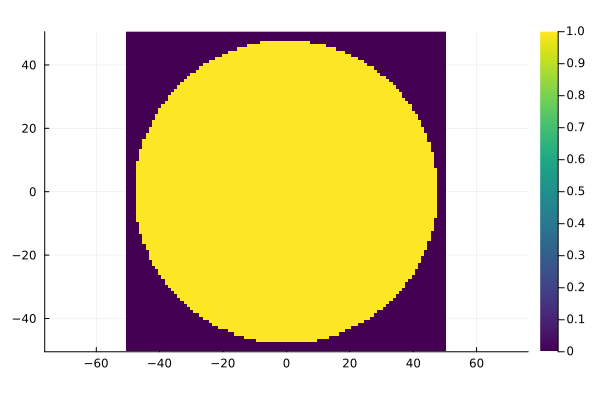

In [152]:
ms = -50:50
ns = -50:50

s = @. λ(E)*sqrt((1/Δx + ms'/ΔL)^2 + (1/Δy + ns/ΔL)^2) 
mask = s.<=1
heatmap(ms, ns, mask, aspect_ratio=1, c=:viridis, colorbar=true, axis=true)

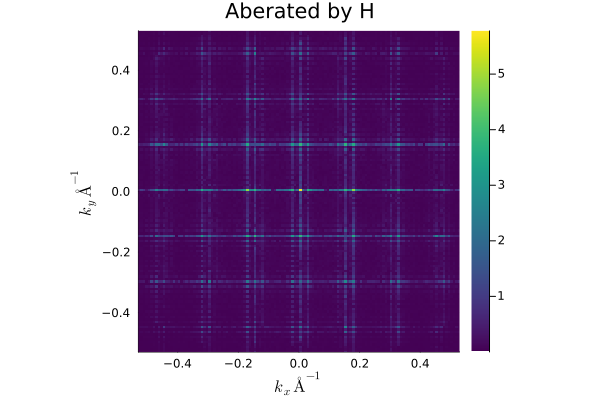

In [295]:
physical = TEM_Image(Ψₜ, E, Cs)
physical_ref = TEM_Image(ref_wave, E, Cs)
physical_measured = @. abs2( physical + physical_ref)
physical_fft = fftnshift(physical_measured)

heatmap(kx,ky,Diff_Image(physical_fft,0.01), 
    aspect_ratio=1, 
    c=:viridis, 
    colorbar=:true, 
    axis=true,
    xlabel=L"k_x\, Å^{-1}",
    ylabel=L"k_y\, Å^{-1}",
    title="Aberated by H")
xlims!(kx[1], kx[end])
ylims!(ky[1], ky[end])

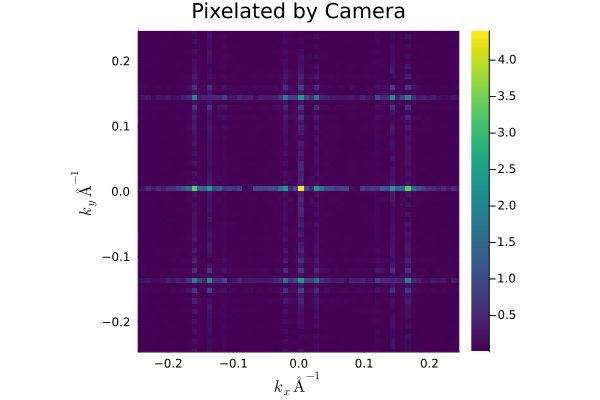

In [296]:
physical_fft_pixelated_in_kspace,kx_camera,ky_camera = Pixelate_Reciprocal(physical_fft, camera_scale, physical_scale)
physical_pixelated = abs.(ifftnshift(physical_fft_pixelated_in_kspace))


heatmap(kx_camera,ky_camera,Diff_Image(physical_fft_pixelated_in_kspace,0.01), 
    aspect_ratio=1, 
    c=:viridis, 
    colorbar=:true, 
    axis=true,
    xlabel=L"k_x\, Å^{-1}",
    ylabel=L"k_y\, Å^{-1}",
    title="Pixelated by Camera")
xlims!(kx_camera[1], kx_camera[end])
ylims!(ky_camera[1], ky_camera[end])

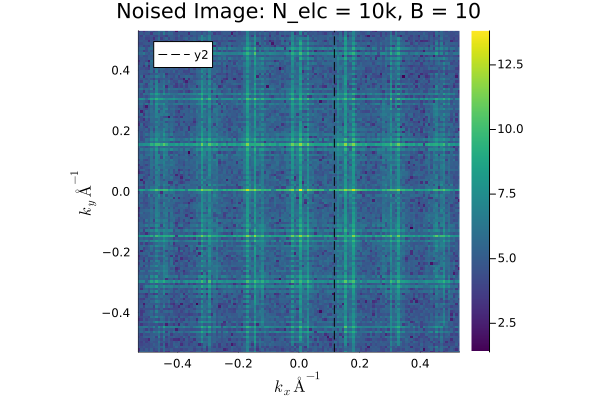

In [297]:
N_electrons = 1e8
B = 10
physical_measured_noised = Noisy_Image(physical_measured, N_electrons, B)
physical_fft_noised = fftnshift(physical_measured_noised)

heatmap(kx, ky, Diff_Image(physical_fft_noised, 0.01), 
    aspect_ratio=1, 
    c=:viridis, 
    colorbar=:true, 
    axis=true,
    xlabel=L"k_x\, Å^{-1}",
    ylabel=L"k_y\, Å^{-1}",
    title="Noised Image: N_elc = 10k, B = $B")
xlims!(kx[1], kx[end])
ylims!(ky[1], ky[end])
vline!([1/8.57], color=:black, linestyle=:dash)

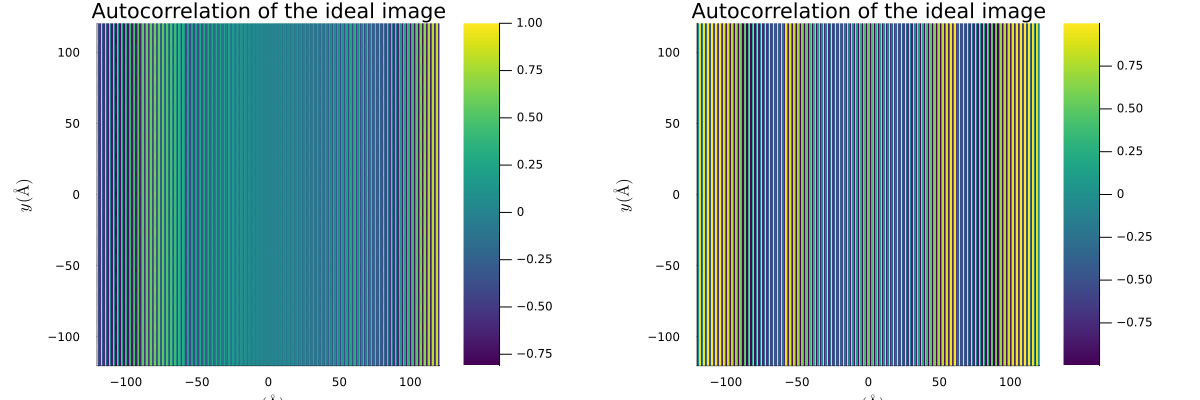

In [356]:

ideal_autocorr = Autocorrelation_Normalized(ideal_measured)
physical_autocorr = Autocorrelation_Normalized(physical_measured)
noisy_autocorr = Autocorrelation_Normalized(physical_measured_noised)
pixelated_autocorr = Autocorrelation_Normalized(physical_pixelated)


mask = ideal_autocorr .< maximum(ideal_autocorr).*0.5 
# println(maximum(imag.(ideal_autocorr))
fig1 = heatmap(x,y, ideal_autocorr, 
    aspect_ratio=1, 
    c=:viridis, 
    colorbar=:true, 
    axis=true,
    xlabel=L"x\, (Å)",
    ylabel=L"y\, (Å)",
    title="Autocorrelation of the ideal image")
    xlims!(-L/2, L/2)
    ylims!(-L/2, L/2)
fig2 = heatmap(x,y, cos.(angle.(ref_wave)), 
    aspect_ratio=1, 
    c=:viridis, 
    colorbar=:true, 
    axis=true,
    xlabel=L"x\, (Å)",
    ylabel=L"y\, (Å)",
    title="Autocorrelation of the physical image")
    xlims!(-L/2, L/2)
    ylims!(-L/2, L/2)
plot(fig1, fig2, layout=(1,2), size=(1200, 400), 
    xlabel=L"x\, (Å)", ylabel=L"y\, (Å)", title="Autocorrelation of the ideal image")


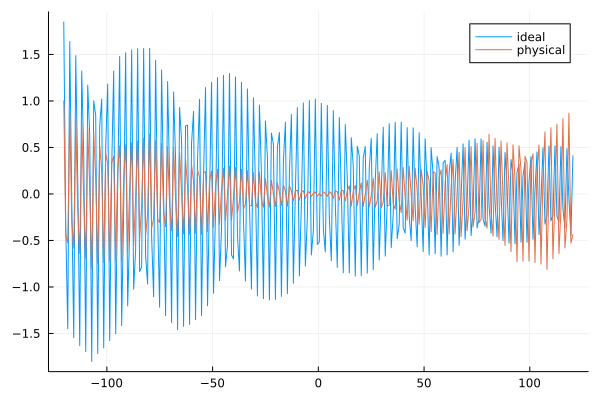

In [357]:
diff = ideal_autocorr .- cos.(angle.(ref_wave))
fig3 = heatmap(x,y, diff, 
    aspect_ratio=1, 
    c=:viridis, 
    colorbar=:true, 
    axis=true,
    xlabel=L"x\, (Å)",
    ylabel=L"y\, (Å)",
    title="Difference")
plot(x,diff[1,:], label="ideal")
plot!(x, ideal_autocorr[1,:], label="physical")
# plot!(x, cos.(angle.(ref_wave)), label="noisy")
# plot!(x, cos.(), label="ideal", linestyle=:dash)

In [358]:
plot(x, ideal_autocorr[:,N÷2], label="ideal")
plot!(x, physical_autocorr[:,N÷2], label="physical", color=:black)
plot!(x[1:camera_scale÷physical_scale:end], pixelated_autocorr[:,N÷2], label="pixelated", color=:red)
plot!(x, noisy_autocorr[:,N÷2], label="noisy", linestyle=:dash)

BoundsError: BoundsError: attempt to access 64×64 Matrix{Float64} at index [1:64, 128]

In [340]:
plot(x, ideal_autocorr[N÷4,:], label="ideal")
plot!(x, physical_autocorr[N÷4,:], label="physical", color=:black)
plot!(x[1:camera_scale÷physical_scale:end], pixelated_autocorr[N÷2,:], label="pixelated", color=:red)
plot!(x, noisy_autocorr[N÷2,:], label="noisy", linestyle=:dash)
plot!(x_intercepts, zeros(length(x_intercepts)), marker=:o, label="x_intercepts")
vline!([0.0, spacing_xaverage])
# vline!([spacing_xaverage])

In [359]:
x_intercepts = Find_Crossing(ideal_autocorr[N÷2,:], 0.0, x)
y_intercepts = Find_Crossing(ideal_autocorr[:,N÷2], 0.0, y)
x_intercepts = Find_Crossing(ideal_autocorr[1,:], 0.0, x)
y_intercepts = Find_Crossing(ideal_autocorr[:,1], 0.0, y)

function Find_Spacing(x_intercepts)
    if length(x_intercepts) == 0
        return Inf
    end


    if mod(length(x_intercepts),2) == 1
        x_intercepts = x_intercepts[1:end-1]
    end
    centers = @. (x_intercepts[1:2:end] + x_intercepts[2:2:end])/2
    
    spacing = centers[2:end] .- centers[1:end-1]
    spacing = sort!(spacing)
    return spacing[length(spacing)÷2]
end
spacing_xaverage = Find_Spacing(x_intercepts)
spacing_yaverage = Find_Spacing(y_intercepts)
println("spacing_xaverage: ", spacing_xaverage)
println("spacing_yaverage: ", spacing_yaverage)
println("wavelength ", Wavelength(E))

spacing_xaverage: 2.8970580758242903
spacing_yaverage: Inf
wavelength 0.019686806700005176


\begin{equation}
    \tan\phi = \frac{\Delta x}{\Delta y} \qquad \sin\theta = \frac{2\pi}{\Delta y \sin\phi |k|} = \frac{2\pi \sqrt{(\Delta x)^2+ (\Delta y)^2}}{\Delta y \Delta x |k|}
\end{equation}

In [111]:
kx_real = 1/(Wavelength(E)) *sin(θ)*cos(ϕ)
ky_real = 1/(Wavelength(E)) *sin(θ)*sin(ϕ)
println("kx_real: ", kx_real, " ky_real ", ky_real)
m_real = ((1/Δx) - kx_real)*ΔL
n_real = ((1/Δy) - ky_real)*ΔL
println("m_real: ", m_real, " n_real ", n_real)
m_obs = round.(ΔL/spacing_xaverage)
n_obs = round.(ΔL/spacing_yaverage)
println("m_obs: ", m_obs, " n_obs", n_obs)

kx_real: 0.8865026564861289 ky_real 0.0
m_real: -0.5067182515262152 n_real 0.0
m_obs: 0.0 n_obs0.0


In [70]:
fs   = 1/ΔL
fobs = 1/Δx          # = f_y_obs here

cands = []
for m = -10:10, n = -10:10
    fx = fobs + m*fs
    fy = fobs + n*fs
    s  = λ(E)*sqrt(fx^2+fy^2)
    if 0 < s ≤ 1             # physical
        push!(cands,(m,n,s,fx,fy))
    end
end
println("candidates: ", cands)

candidates: Any[(-10, -10, 0.28634227948824575, -10.28478466070879, -10.28478466070879), (-10, -9, 0.27194418975047235, -10.28478466070879, -9.22153283937322), (-10, -8, 0.2584408707485849, -10.28478466070879, -8.15828101803765), (-10, -7, 0.2459797248255681, -10.28478466070879, -7.095029196702081), (-10, -6, 0.2347267909612519, -10.28478466070879, -6.031777375366511), (-10, -5, 0.22486353146386792, -10.28478466070879, -4.968525554030942), (-10, -4, 0.21657989100460404, -10.28478466070879, -3.9052737326953726), (-10, -3, 0.21006282538912024, -10.28478466070879, -2.842021911359803), (-10, -2, 0.20548049068240878, -10.28478466070879, -1.7787700900242336), (-10, -1, 0.2029639709639042, -10.28478466070879, -0.7155182686886641), (-10, 0, 0.20259026379744713, -10.28478466070879, 0.3477335526469055), (-10, 1, 0.20437112437751936, -10.28478466070879, 1.410985373982475), (-10, 2, 0.20825128568840423, -10.28478466070879, 2.4742371953180444), (-10, 3, 0.2141166493296232, -10.28478466070879, 3.537

In [360]:
Δx = spacing_xaverage
Δy = spacing_yaverage
ϕ_measured = atan(Δx, Δy)
θ_measured = asin(Wavelength(E)*sqrt(Δx^2 + Δy^2)/(Δx*Δy))
println(π/2)
println("ϕ_measured: ", rad2deg(ϕ_measured))
println("θ_measured: ", rad2deg(θ_measured))
println(round(deg2rad(1)*kmag/(1/ΔL), digits=2))

1.5707963267948966
ϕ_measured: 0.0
θ_measured: NaN
5.24


In [32]:
println(1/spacing_xaverage + 12/ΔL) 
println(1/Wavelength(E)*deg2rad(1))

12.87556190781275
0.8865476654443255


In [ ]:

# function reference_model(A, C, θ_polar,ϕ_azi)
#     return @. A*cos(2π/Wavelength(E) * sin(θ_polar)*(cos(ϕ_azi)*x' + sin(ϕ_azi)*y)) + C
# end

# model_ref = Model(Ipopt.Optimizer)
# @variable(model_ref, A_const, start=maximum(ideal_autocorr))
# @variable(model_ref, C_const)
# # @variable(model_ref, θ_polar, lower_bound=0, upper_bound=π, start=θ)
# # @variable(model_ref, ϕ_azi, lower_bound=0, upper_bound=2π, start = ϕ)
# @variable(model_ref, θ_polar, lower_bound=0, upper_bound=π/2)
# @variable(model_ref, ϕ_azi, lower_bound=0, upper_bound=2π)

# ref_term = @expression(model_ref, reference_model(A_const, θ_polar, ϕ_azi)) 


# # costb = @expression(model, smooth_penalty(b))


# @objective(model_ref, Min,
#     sum((ref_term .- ideal_autocorr).^2))


# set_optimizer_attribute(model_ref, "print_level", 5)
# optimize!(model_ref)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.5960181e+04 0.00e+00 1.06e+06  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

InterruptException: InterruptException:

In [72]:
using JuMP
using Ipopt

In [184]:
println(value(θ_polar), " ", value(ϕ_azi), " ", value(A_const), " ", value(C_const))
println("should get ", θ, " ", ϕ)

1.5707963268208955 0.7853981633974484 1.0000152661383224 0.0
should get 1.5707963267948966 0.7853981633974483


In [ ]:
# # model_fitting = reference_model(value(A_const), value(θ_polar), value(ϕ_azi))
# model_fitting = reference_model(1,0, θ_measured, ϕ_measured)
# # model_fitting = reference_model(1, θ, ϕ)

# fig1 = heatmap(x,y, model_fitting, 
#     aspect_ratio=1, 
#     c=:viridis, 
#     colorbar=:true, 
#     axis=true,
#     xlabel=L"x\, (Å)",
#     ylabel=L"y\, (Å)",
#     title="Fitted Model")
#     xlims!(-L/2, L/2)
#     ylims!(-L/2, L/2)
# model_expected = reference_model(1,0, θ, ϕ)
# model_expected = cos.(model_expected)
# fig2 = heatmap(x,y, model_expected, 
#     aspect_ratio=1, 
#     c=:viridis, 
#     colorbar=:true, 
#     axis=true,
#     xlabel=L"x\, (Å)",
#     ylabel=L"y\, (Å)",
#     title="Fitted Model")
# xlims!(-L/2, L/2)
# ylims!(-L/2, L/2)

# plot(fig1, fig2, layout=(1,2), size=(1200, 400), 
#     xlabel=L"x\, (Å)", ylabel=L"y\, (Å)", title="Fitted Model")


UndefVarError: UndefVarError: `reference_model` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

UndefVarError: UndefVarError: `model_fitting` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [73]:
# N = 2^7
# amk = Array{Any}(undef, N)
# z::Vector{Float64} = LinRange(0, 10, N)
# m = 20
# b = 0.4
# # x = 0:0.1:10
# noise = randn(length(z))
# y = @. sin(m*z) + b 
# y_fft = abs.(fftshift(fft(y)))




# plot(z, y, label="data")
# plot!(z, y_fft, label="fft")

In [74]:
# struct MinimizingFunc
#     x::Vector{Float64}
#     y::Vector{Float64}
#     kmag::Float64
#     y_data::Vector{Float64}
#     # amk::Array{Any, 3}
#     # params::Vector{Float64}
# end
# function (pv::MinimizingFunc)(m, b)

   
#     model_real = @. sin(m*pv.x) + b
#     model_imag = model_real.*zero(model_real)


    

#     fft_1dgpt!(model_real, model_imag)
#     # model_abs = @. sqrt(model_real^2 + model_imag^2)
#     # half_real = model_fft[1:2:end]

    
#     obj = sum((model_real .- pv.y_data).^2)

#     return obj
# end

In [75]:
# model = Model(Ipopt.Optimizer)
# set_silent(model)
# ConstraintFunc = MinimizingFunc(z, y_fft)

# q = @variable(model, start=m)
# p = @variable(model, start=b)
# @variable(model, x[1:3, 1:2])
# @variable(model, y[1:3, 1:2])
# @variable(model, ams[1:3, 1:2])

# # ams = @expression(model, ConstraintFunc(φ))

# # @constraint(model, ams[1] == ams[2])


# @objective(model, Min, ConstraintFunc(q,p))
# optimize!(model)

In [76]:
q_sol = value(q)
p_sol = value(p)
println("Solution:")
println("q = ", q_sol)
println("p = ", p_sol)
model_fit = @. sin(q_sol*z) + .1
model_fit_fft = abs.(fftshift(fft(model_fit)))
plot(z, model_fit_fft, label="model fit", linestyle=:dash)
plot!(z, y_fft, label="fft")


UndefVarError: UndefVarError: `q` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [94]:
println(Wavelength(E))

0.019686806700005176


In [187]:
using Pkg
Pkg.add("Optimization")
Pkg.add("OptimizationBBO")

   Resolving package versions...
   Installed L_BFGS_B_jll ───────────── v3.0.1+0
   Installed ConsoleProgressMonitor ─── v0.1.2
   Installed LBFGSB ─────────────────── v0.4.1
   Installed OptimizationBase ───────── v2.5.0
   Installed TerminalLoggers ────────── v0.1.7
   Installed ProgressLogging ────────── v0.1.4
   Installed SparseConnectivityTracer ─ v0.6.17
   Installed Optimization ───────────── v4.1.2
    Updating `~/.julia/environments/v1.11/Project.toml`
  [7f7a1694] + Optimization v4.1.2
    Updating `~/.julia/environments/v1.11/Manifest.toml`
  [88cd18e8] + ConsoleProgressMonitor v0.1.2
  [5be7bae1] + LBFGSB v0.4.1
  [e6f89c97] + LoggingExtras v1.1.0
  [7f7a1694] + Optimization v4.1.2
  [bca83a33] + OptimizationBase v2.5.0
  [33c8b6b6] + ProgressLogging v0.1.4
  [9f842d2f] + SparseConnectivityTracer v0.6.17
  [5d786b92] + TerminalLoggers v0.1.7
  [81d17ec3] + L_BFGS_B_jll v3.0.1+0
Precompiling project...
   2059.3 ms  ✓ ProgressLogging
   2292.0 ms  ✓ L_BFGS_B_jll
   2050.1 

In [278]:
using Optimization, OptimizationBBO

function reference_term(θ_polar,ϕ_azi)
    return @. 2π/Wavelength(E) * sin(θ_polar)*(cos(ϕ_azi)*x' + sin(ϕ_azi)*y)
end
const rf_wave = reference_term(θ,ϕ)

function ll_termbb(x)
    # Reshape x into a 3D array of size (Ny, Nx, 2)
    x_mat = reshape(x, Ty, Tx, 2)
    
    # arg = zeros(Ny, Nx)
    # for i in 1:Ny, j in 1:Nx
    #     # Use proper indexing: use l for the second index in the third argument
    #     # (the previous code accidentally used x[k,k,2], should likely be x[k,l,2])
    #     k = mod(i-1, Ty) + 1
    #     l = mod(j-1, Tx) + 1
    #     arg[i,j] = exp(-2*x_mat[k,l,1]) + 1 + 2*exp(-x_mat[k,l,1])*cos(x_mat[k,l,2] + rf_wave[i,j])
    # end
    A = @. exp(-2 * x_mat[:,:,1]) + 1 + 2 * exp(-x_mat[:,:,1]) * cos(x_mat[:,:,2] + rf_wave[1:Ty,1:Tx])

    return sum((A.-ideal_measured[1:Ty,1:Tx]).^2)
end

# x0 = zeros(Ny, Nx, 2)
# p = [1.0, 100.0]
# x0_array = zeros(Ny, Nx, 2)
x0 = sol_previous
# x0 = sol_previous[1:Ty,1:Tx]
lb = zeros(length(x0))  # lower bound as vector
ub = fill(10, length(x0))  # upper bound as vector
f_bb = OptimizationFunction((x, _) -> ll_termbb(x))
prob = Optimization.OptimizationProblem(f_bb, x0, lb = lb, ub = ub)
sol = solve(prob, BBO_adaptive_de_rand_1_bin_radiuslimited(), maxiters = 100000,
    maxtime = 520.0)

retcode: MaxTime
u: 8192-element Vector{Float64}:
 9.989358785201233
 9.931401019613412
 9.759094608932738
 9.996439468508274
 0.9409055823157099
 0.07014113943121565
 0.000694901511089483
 0.5131541033396075
 9.895776032918489
 9.998494570207152
 ⋮
 1.0018113630428047
 1.8314360831776728
 2.1822613838098013
 1.336620643391389
 7.36161969641068e-5
 2.037978347070693e-7
 0.4329919239914197
 1.0763803948388913
 1.4975519542725844

In [246]:
best_candidate = sol.minimizer

132098-element Vector{Float64}:
 1.2174759885902075e-5
 0.005422233684307303
 2.7193429872993695
 8.523311756355995e-6
 0.003843001055109881
 0.0018007400273281056
 0.00023079935141815077
 0.00068180018266788
 0.0003030194921024186
 0.0010093539640187027
 ⋮
 0.003459767935603105
 2.055958731921903
 1.922304842879474
 0.00016802639665652416
 7.033173844094319e-5
 0.001856023800932133
 0.0024203553095733794
 0.0051326147110683056
 0.0003091525193952343

In [227]:
fieldnames(typeof(sol))

(:u, :cache, :alg, :objective, :retcode, :original, :stats)

In [279]:
sol.stats

SciMLBase.OptimizationStats
Number of iterations:                              3755085
Time in seconds:                                   520.240329
Number of function evaluations:                    3755489
Number of gradient evaluations:                    0
Number of hessian evaluations:                     0

In [277]:
sol_previous = sol.u
# sol_square = reshape(sol.u, Ny, Nx, 2)
# sol_square = sol_square[1:Ty, 1:Tx, :]

8192-element Vector{Float64}:
 7.8097870198835135
 9.735007817069194
 9.759121928058427
 9.92382425401308
 0.9373629681978733
 0.07309988905802627
 0.0015136168468338647
 0.45872995062727795
 9.756355842520446
 6.991746471134604
 ⋮
 1.0000025713620102
 1.8104723132441551
 2.1804243483465786
 1.3362069357728432
 0.017696539996038516
 2.88956917275183e-5
 0.41718077103252127
 1.0786063197808495
 1.5048320699859594

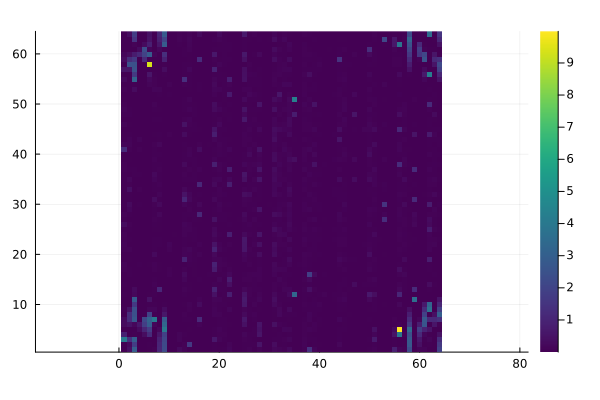

In [283]:
x_mat = reshape(sol.u, Ty, Tx, 2)

heatmap(x_mat[:,:,2], aspect_ratio=1, c=:viridis, colorbar=true, axis=true)

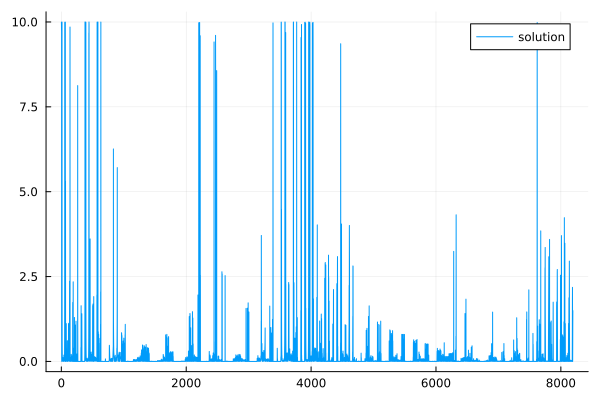

In [282]:
plot(1:length(sol.u), sol.u, label="solution")

In [380]:
using JuMP, Ipopt, ForwardDiff
using MAiNGO

Tx = 64
Ty = 64
Ny, Nx = size(ideal_measured)          # detector grid
λi, λr = 1e-2, 1e-2
# λi, λr, λb = 0, 0, 0

model=Model(Ipopt.Optimizer)
# @variable(model, φi[1:Nx,1:Ny], start = phase_real)
# @variable(model, φr[i=1:Nx, j=1:Ny], start = phase_real[i,j])
@variable(model, φr[i=1:Ty, j=1:Tx], start=phase_unwrapped[i,j])
@variable(model, φi[i=1:Ty, j=1:Tx], start=phase_unwrapped[i,j]/π*0.05, lower_bound=0.0, upper_bound=0.10)
# @variable(model, re_c)
# @variable(model, im_c)
# @variable(model, B[i=1:Ny, j=1:Nx], start=0.0)
# @variable(model, φr[1:Nx,1:Ny], start = phase_complex)
# @variable(model, φi[i=1:Nx, j=1:Ny], start = phase_complex[i,j],
#          lower_bound=-0.1, upper_bound=0.10)


# function phi_grid(φi::T, φr::T, Nx, Ny) where {T<:AbstractArray{VariableRef}}
    #     φi_grid = Matrix{NonlinearExpr}(undef, Ny, Nx)
    #     φr_grid = Matrix{NonlinearExpr}(undef, Ny, Nx)
    #     # φi_grid = zeros(Ny, Nx)
    #     # φr_grid = zeros(Ny, Nx)
        
    #     # φi_grid[1:Tx, 1:Ty] = φi
    #     # φr_grid[1:Tx, 1:Ty] = φr
    #     for i in 1:Ny
    #         i_peri = mod(i-1, Tx) + 1
    #         for j in 1:Nx
    #             j_peri = mod(j-1, Ty) + 1
    #             φi_grid[i, j] = φi[i_peri, j_peri]
    #             φr_grid[i, j] = φr[i_peri, j_peri]
    #         end
    #     end
    #     return φi_grid, φr_grid
    # end
@expression(model, φr_grid[i=1:Ny, j=1:Nx],
    φr[mod(i-1,Ty)+1, mod(j-1,Tx)+1])
@expression(model, φi_grid[i=1:Ny, j=1:Nx],
    φi[mod(i-1,Ty)+1, mod(j-1,Tx)+1])


# Usage:
# full_φi, full_φr = phi_grid(φi, φr, N, N)
# @variable(model,  b[1:Nx,1:Ny])
# @variable(model, θ_polar, lower_bound=0, upper_bound=π, start = 0)
# @variable(model, ϕ_azi, lower_bound=0, upper_bound=2π, start = deg2rad(45))
# @variable(model, λi_model, lower_bound=0)
# @variable(model, λr_model, lower_bound=0)

function reference_term(θ_polar,ϕ_azi)
    return @. 2π/Wavelength(E) * sin(θ_polar)*(cos(ϕ_azi)*x' + sin(ϕ_azi)*y)
end


# function ll_term(φi, φr)
#     ref_wave = @. reference_term(θ,ϕ)
#     model_for_I = @. exp(-2*φi) + 1 + 2*exp(-φi)*cos(φr - ref_wave) 
#     arg = @. ideal_measured*log(model_for_I + eps()) - model_for_I
#     return sum((arg))
# end

function ll_term(φi, φr)
    ref_wave = @. reference_term(θ,ϕ)
    Î = @. exp(-2*φi) + 1 + 2*exp(-φi)*cos(φr - ref_wave) 
    return -0.5* sum((Î .- ideal_measured).^2)
end

function smooth_penalty(φ)
    return sum(@. (φ[2:end,:] - φ[1:end-1,:])^2) +
           sum(@. (φ[:,2:end] - φ[:,1:end-1])^2)
end

function ll_term(φi, φr)
    ref_wave = @. 2π/Wavelength(E) * sin(θ)*(cos(ϕ)*x' + sin(ϕ)*y)
    Î = @. exp(-2*φi) + 1 + 2*exp(-φi)*cos(φr - ref_wave) 
    return -0.5* sum((Î .- ideal_measured).^2)
end

# llterm = @expression(model, ll_term(φi_grid, φr_grid)) 
# costϕi = @expression(model, smooth_penalty(φi_grid))
# costϕr = @expression(model, smooth_penalty(φr_grid))

# costb = @expression(model, smooth_penalty(b))
function Wavelength(E)
    hc = 12.398 #keV*Angstrom
    # h = 6.582119e-16 #eV*sec
    # mc2 = 511 #keV
    E₀ = 511 #keV
    return hc/sqrt(E*(2*E₀ + E))
end
hc = 12.398
E₀ = 511 #keV
WL = hc/sqrt(300*(2*E₀ + 300))
# @NLobjective(model, Max, llterm)

@NLobjective(model, Max,
    -0.5 * sum(
       ( exp(-2*φi_grid[i,j]) + 1 + 2*exp(-φi_grid[i,j])*cos(φr_grid[i,j] -
         (2π/WL*sin(θ)*(cos(ϕ)*x[j] + sin(ϕ)*y[i]))) - ideal_measured[i,j] )^2
       for i = 1:Ny, j = 1:Nx )
)
# set_optimizer_attribute(model, "hessian_approximation", "limited-memory")
# set_optimizer_attribute(model, "print_level", 5)
optimize!(model)


This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    12288

Total number of variables............................:     8192
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     4096
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.3432771e+04 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [381]:
println("Objective value: ", objective_value(model))
# println("θi: ", value(θ_polar))
# println("ϕ: ", value(ϕ_azi))

Objective value: -6535.483419600582


starting at \theta = 0 and \phi = 45

Objective value: -3824.890931924671

θi: 0.010091737353136943

ϕ: 6.215507323212204

setting \theta = \theta_{measured} and \phi = \phi_measured

Objective value: -9988.569070201866

θi: 0.180091 degrees

ϕ: 45 degrees

better than the one above, phase_re is still jagged but is 3\pi. phase_im is awful

setting a lower_bound = 0 for both phi_re and phi_im

Objective value: -21221.856466329973

worse

starting at \theta = 0 and \phi = 45

Objective value: -23861.22672099034

In [382]:
function phi_grid(φi, φr, Nx, Ny) 
    φi_grid = Matrix{Float64}(undef, Ny, Nx)
    φr_grid = Matrix{Float64}(undef, Ny, Nx)
    # φi_grid = zeros(Ny, Nx)
    # φr_grid = zeros(Ny, Nx)
    
    # φi_grid[1:Tx, 1:Ty] = φi
    # φr_grid[1:Tx, 1:Ty] = φr
    for i in 1:Ny
        i_peri = mod(i-1, Tx) + 1
        for j in 1:Nx
            j_peri = mod(j-1, Ty) + 1
            φi_grid[i, j] = φi[i_peri, j_peri]
            φr_grid[i, j] = φr[i_peri, j_peri]
        end
    end
    return φi_grid, φr_grid
end

phi_grid (generic function with 1 method)

In [198]:
using Pkg
Pkg.add("DSP")
using DSP

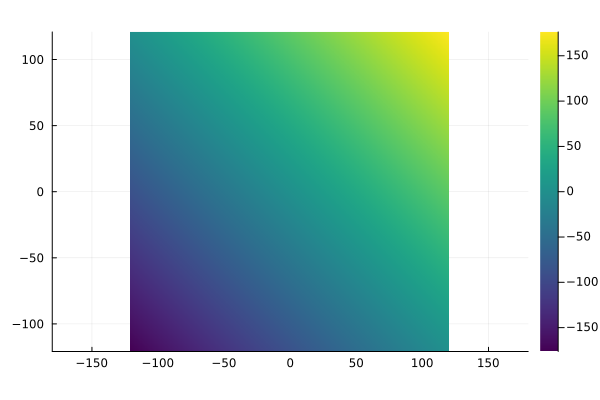

In [154]:
ref_wave_test = @. reference_term(θ_measured, ϕ_measured)
heatmap(x,y, ref_wave_test, aspect_ratio=1, c=:viridis, colorbar=true, axis=true)

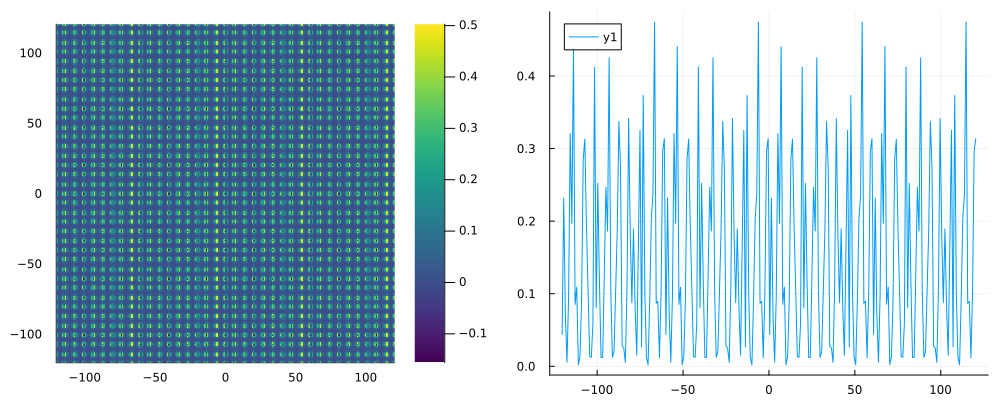

In [383]:
phase_r = value.(φr)
phase_i = value.(φi)
# b_retrieved = value.(B)
# using Unwrap
# θ_infered = value(θ_polar)
# ϕ_infered = value(ϕ_azi)
# println("θ_infered: ", rad2deg(θ_infered))
# println("ϕ_infered: ", rad2deg(ϕ_infered))
phase_im, phase_re = phi_grid(phase_i, phase_r, N, N)
typeof(phase_re)

phase_reconstruced = @. phase_re + 1im*phase_im
ψ_reconstruced = @. exp(1im*phase_reconstruced)
fig = heatmap(x,y,unwrap(angle.(ψ_reconstruced),(true, true)), aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
xlims!(-L/2, L/2)
ylims!(-L/2, L/2)
fig2 = plot(x, unwrap(angle.(ψ_reconstruced),(true, true))[1,:])
plot(fig,fig2, layout=(1,2), size=(1000,400))
# plot(x, DSP.Unwrap.unwrap(angle.(ψ_reconstruced[1,:])))

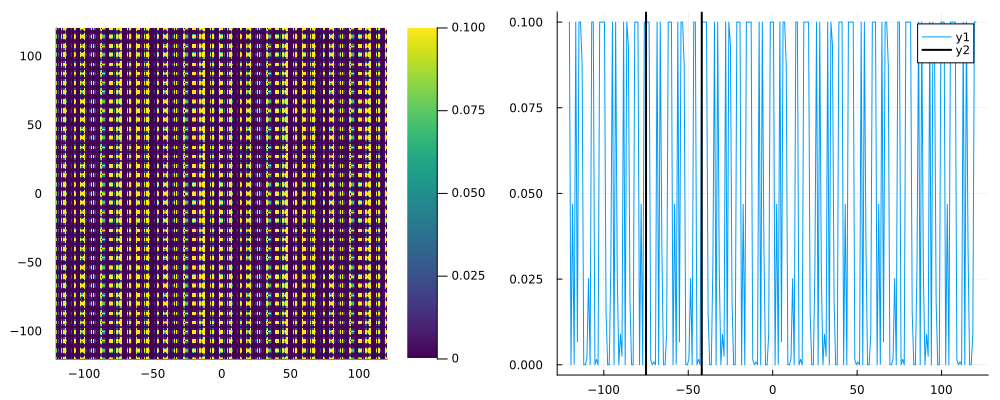

In [384]:
fig1 = heatmap(x,y, phase_im, aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
xlims!(-L/2,L/2)
ylims!(-L/2,L/2)
fig2 = plot(x,phase_im[N÷2,:])
x_start = -75
x_end = -42
vline!([x_start, x_end], color=:black, lw=2)
plot(fig1, fig2, layout = (1,2), size=(1000,400))


In [149]:
N_start = round(Int, abs(x_start/ΔL))
N_end = round(Int, abs(x_end/ΔL))
println(N_start, " ", N_end)
sum(phase_im[1,N_end:N_start])

80 45


1.3337182598443302

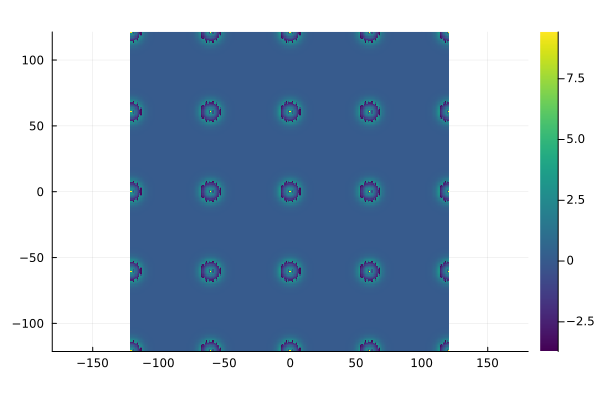

In [150]:
ψ_reconstruced = @. exp(1im*phase_reconstruced)
heatmap(x,y, phase_re, aspect_ratio=1, c=:viridis, colorbar=true, axis=true)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     4098
                     variables with only lower bounds:     4096
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.3044936e+05 0.00e+00 1.32e+03   0.0 0.00e+00    -  0.00e+00 0.00e+00 

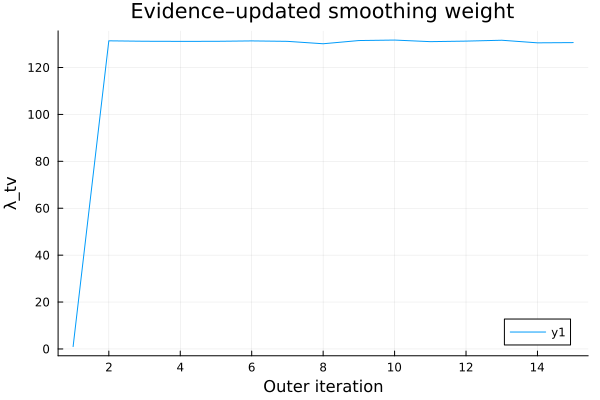

In [110]:
using JuMP, Ipopt, Plots

# ---------- initial setup ----------
Nx, Ny      = 256, 256
a, b        = 1.0, 1e-3            # Gamma hyper‑parameters
λ_history   = Float64[]            # store λ at every outer pass
δ           = 0.05                 # Huber width

λ_tv = 1.0                         # initial value
max_outer = 15                     # outer evidence iterations


model = Model(Ipopt.Optimizer)
@NLparameter(model, λ_curr==1)
@variable(model, A_r)
@variable(model, A_i)

@variables(model, begin
    0 <= φr[1:Tx,1:Ty]     # tile variables
end)

@NLexpression(model, φr_grid[i=1:Nx, j=1:Ny],
    A_r * φr[mod(i-1,Tx)+1, mod(j-1,Ty)+1])
@NLexpression(model, φi_grid[i=1:Nx, j=1:Ny],
    A_i * φr[mod(i-1,Tx)+1, mod(j-1,Ty)+1])

δ = 0.05
# @NLexpression(model, TV[i=1:Ny-1,j=1:Nx-1],
#     sqrt((φr_grid[i+1,j]-φr_grid[i,j])^2 + 1e-12 + δ^2) - δ)

ref_wave = reference_term(θ, ϕ)
# register(model, :sum, 1, sum; autodiff = true)
@NLexpression(model, TVsum,
    sum(sqrt((φr_grid[i+1,j]-φr_grid[i,j])^2 + 1e-12 + δ^2) - δ for i=1:Ny-1, j=1:Nx-1))
@NLexpression(model, ll,
-0.5 * sum((exp(-2*φi_grid[i,j]) + 1 +
            2*exp(-φi_grid[i,j])*cos(φr_grid[i,j]-ref_wave[i,j])
            - ideal_measured[i,j])^2
            for i=1:Ny, j=1:Nx))
for outer = 1:max_outer
    # ----- build or rebuild the model -----
        
        # current λ as parameter
    # ... declare φ variables and Huber‑TV expression TVsum ...
    
    # @NLparameter(model, λ_tv, 1.0)
    
    
    @NLobjective(model, Max, ll - λ_curr * TVsum)


    # @NLobjective(model, Max,
    #     loglikelihood(φr_grid, φi_grid) - λ_curr * TVsum)


    set_optimizer_attribute(model, "hessian_approximation", "limited-memory")
    optimize!(model)

    # ----- extract current phase & TV value -----
    Rϕ = value(TVsum)                       # JuMP evaluates expression
    Ngrad = 2 * Nx * Ny                     # horizontal + vertical diffs

    # ----- update λ from Gamma posterior -----
    # set_value(λ_curr, (a + Ngrad - 1) / (b + Rϕ) )
    # λ_curr = (a + Ngrad - 1) / (b + Rϕ)       # mode; use +0 instead of −1 for mean
    push!(λ_history, value(λ_curr))                  # store trajectory
    set_value(λ_curr, rand(Gamma((a + Ngrad - 1),(b + Rϕ))))
    # set_value(λ_curr, (a + Ngrad - 1) / (b + Rϕ) )

end

# ---------- plot diagnostic ----------
plot(λ_history, xlabel="Outer iteration", ylabel="λ_tv",
     title="Evidence–updated smoothing weight")


In [111]:
λ_history 

15-element Vector{Float64}:
   1.0
 131.38341624480367
 131.20249147048386
 131.15442673454422
 131.1762679843082
 131.34895743236922
 131.16024065431202
 130.13483669793467
 131.502458265647
 131.70784005107325
 131.03427750931473
 131.2622324447215
 131.63212301857942
 130.52725032315135
 130.62948496309969

┌ Warning: No strict ticks found
└ @ PlotUtils /home/nicolas/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/nicolas/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
GKS: Rectangle definition is invalid in routine CELLARRAY
┌ Warning: No strict ticks found
└ @ PlotUtils /home/nicolas/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/nicolas/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
GKS: Rectangle definition is invalid in routine CELLARRAY
┌ Warning: No strict ticks found
└ @ PlotUtils /home/nicolas/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/nicolas/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/nicolas/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
GKS: Rectangle definition is invalid in routine CELLARRAY


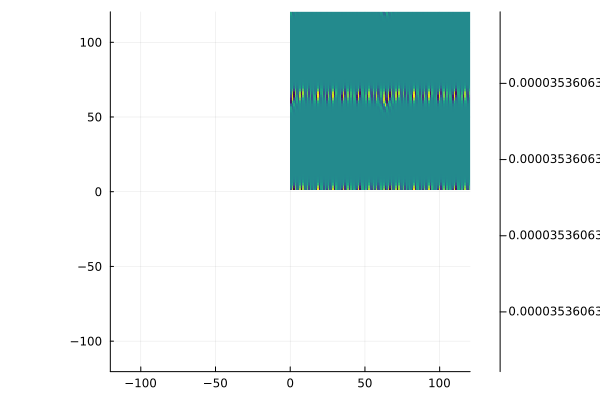

In [112]:
phase_r = value.(φr)
# phase_i = value.(φi)
# θ_infered = value(θ_polar)
# ϕ_infered = value(ϕ_azi)
# println("θ_infered: ", rad2deg(θ_infered))
# println("ϕ_infered: ", rad2deg(ϕ_infered))
function phi_grid(φr, φi, Nx, Ny, A, B)
    φr_grid = Matrix{Any}(undef, Ny, Nx)
    φi_grid = Matrix{Any}(undef, Ny, Nx)

    for i in 1:Ny
        i_peri = mod(i-1, Tx) + 1
        for j in 1:Nx
            j_peri = mod(j-1, Ty) + 1
            φr_grid[i, j] = A*φr[i_peri, j_peri]
            φi_grid[i, j] = B*φr[i_peri, j_peri]
        end
    end
    return φr_grid, φi_grid
end
phase_re, phase_im = phi_grid(phase_r, phase_r, N, N, value(A_r), value(A_i))

# phase_reconstruced = @. phase_re + 1im*phase_im
# ψ_reconstruced = @. exp(1im*phase_reconstruced)
heatmap(phase_re, aspect_ratio=1, c=:viridis, colorbar=true, axis=true)
xlims!(-L/2, L/2)
ylims!(-L/2, L/2)

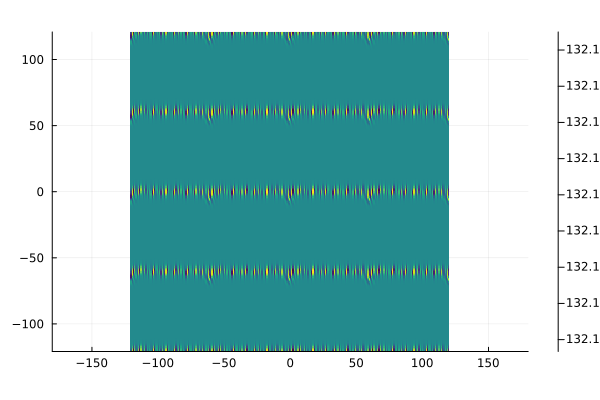

GKS: Rectangle definition is invalid in routine CELLARRAY
GKS: Rectangle definition is invalid in routine CELLARRAY
GKS: Rectangle definition is invalid in routine CELLARRAY


In [113]:
heatmap(x,y, phase_im, aspect_ratio=1, c=:viridis, colorbar=true, axis=true)

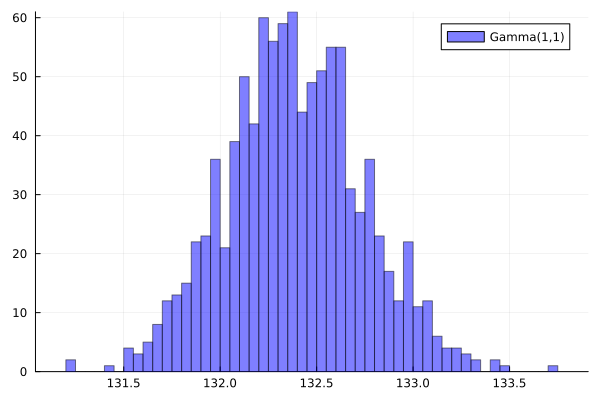

In [114]:
using Distributions
values = rand(Gamma((a + 2*N^2 - 1),(b + 1e-5)), 1000)
histogram(values, bins=50, alpha=0.5, label="Gamma(1,1)", color=:blue)